#### Pet Classification Model Using CNN.

PROJECT DESCRIPTION

Build a CNN model that classifies the given pet images correctly into dog and cat images. 

The CNN model is having the following layers: 

        Input layer 

        Convolutional layer 1 with 32 filters of kernel size[3, 3] 
        Pooling layer 1 with pool size[2,2] and stride 2 

        Convolutional layer 2 with 64 filters of kernel size[3, 3] 
        Pooling layer 2 with pool size[2,2] and stride 2 

        Flattening the Input 

        Dense layer with 64 nodes, activation 'ReLU' dropout = 0.2

        Dense layer with 32 nodes, activation 'ReLU' dropout = 0.4

        Output layer with 1 node, activation 'Sigmoid'

In [10]:
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, Activation, Dropout
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.backend import image_data_format
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from glob import glob
import datetime as dt
import numpy as np
import cv2
import os
%matplotlib inline

In [11]:
train_path = r'../input/petclassdata/pet_class_data/train'
test_path = r'../input/petclassdata/pet_class_data/test'

In [12]:
os.listdir(train_path), os.listdir(test_path)

(['cats', 'dogs'], ['cats', 'dogs'])

In [13]:
# creating Image generator to create more data samples
train_gen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.25,
            fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1./255)

def create_sample_dataset(train_path, test_path, train_samples=0, test_samples=0):
    # creating samples for training data
    for fold in os.listdir(train_path):
        for t_img in glob(train_path + '/' + fold + '/*.jpg'):
            img = img_to_array(load_img(t_img))
            img = img.reshape((1,) + img.shape)
            i = 0
            for batch in train_gen.flow(img, 
                                         batch_size=1,
                                         save_to_dir=train_path + '/' + fold,
                                         save_prefix=fold,
                                         save_format='jpg'):
                if i == new_train_samples:
                    break
                i += 1


    # creating samples for testing data
    for fold in os.listdir(test_path):
        for t_img in glob(test_path + '/' + fold + '/*.jpg'):
            img = img_to_array(load_img(t_img))
            img = img.reshape((1, ) + img.shape)
            i = 0
            for batch in test_gen.flow(img, 
                                         batch_size=1,
                                         save_to_dir=test_path + '/' + fold,
                                         save_prefix=fold,
                                         save_format='jpg'):
                if i == new_test_samples:
                    break
                i += 1

In [14]:
# new_train_samples = 50
# new_test_samples = 20
# create_sample_dataset(train_path, test_path, new_train_samples, new_test_samples)

In [15]:
batch_size = 32
train_image = train_gen.flow_from_directory(train_path,
                                           target_size=(150, 150),
                                           batch_size=batch_size,
                                           subset='training',
                                           class_mode='binary')

validation_image = train_gen.flow_from_directory(train_path,
                                           target_size=(150, 150),
                                           batch_size=batch_size,
                                           subset='validation',
                                           class_mode='binary')

if image_data_format == 'channels_first':
    input_shape = (3, 150, 150)
else:
    input_shape = (150, 150, 3)

Found 1469 images belonging to 2 classes.
Found 489 images belonging to 2 classes.


In [19]:
def get_model():
    model = Sequential()

    # First Convolutional layer
    model.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second Convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flattening the input
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
             optimizer='adam',
            #  optimizer='sgd',
            #  optimizer='rmsprop',
             metrics=['accuracy'])

    print('Model building done')
    return model


def run_model(model, train_samples, test_samples, train_image, test_image, iteration=0, batch_size=8):
    my_callbacks = [
#     EarlyStopping(patience=8),
    ModelCheckpoint(filepath='../model_cp.{epoch:02d}-{val_loss:.2f}.h5')
#     TensorBoard(log_dir='/content/drive/My Drive/datasets/pet_class_data/model_checkpoint/logs')
    ]
    model.fit_generator(train_image,
                   steps_per_epoch=train_samples//batch_size,
                   epochs=iteration,
                   validation_steps=test_samples//batch_size,
                   callbacks = my_callbacks,
                   validation_data=validation_image
                   )
    # list all data in history
    history = model.history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()  

In [20]:
train_samples, validation_samples = train_image.samples, validation_image.samples
print('Total train samples: {} and classes {}\nTotal test samples: {} and classes {}'.format(train_samples, np.unique(train_image.classes), validation_samples, np.unique(validation_image.classes)))
my_model = get_model()
my_model.summary()

Total train samples: 1469 and classes [0 1]
Total test samples: 489 and classes [0 1]
Model building done
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2654272   
______________

Model building done
Epoch 1/150
45/45 [==============================] - 16s 353ms/step - loss: 0.6969 - accuracy: 0.5073 - val_loss: 0.6749 - val_accuracy: 0.4979
Epoch 2/150
45/45 [==============================] - 16s 358ms/step - loss: 0.6799 - accuracy: 0.5191 - val_loss: 0.6690 - val_accuracy: 0.5542
Epoch 3/150
45/45 [==============================] - 16s 362ms/step - loss: 0.6758 - accuracy: 0.5317 - val_loss: 0.6658 - val_accuracy: 0.5708
Epoch 4/150
45/45 [==============================] - 16s 361ms/step - loss: 0.6723 - accuracy: 0.5588 - val_loss: 0.6581 - val_accuracy: 0.5979
Epoch 5/150
45/45 [==============================] - 15s 338ms/step - loss: 0.6542 - accuracy: 0.5755 - val_loss: 0.6342 - val_accuracy: 0.6375
Epoch 6/150
45/45 [==============================] - 16s 348ms/step - loss: 0.6261 - accuracy: 0.6319 - val_loss: 0.6108 - val_accuracy: 0.6625
Epoch 7/150
45/45 [==============================] - 17s 374ms/step - loss: 0.5690 - accuracy: 0.6924 - val_loss: 0.

45/45 [==============================] - 15s 326ms/step - loss: 0.0985 - accuracy: 0.9631 - val_loss: 0.0701 - val_accuracy: 0.9812
Epoch 58/150
45/45 [==============================] - 15s 323ms/step - loss: 0.0789 - accuracy: 0.9749 - val_loss: 0.0605 - val_accuracy: 0.9833
Epoch 59/150
45/45 [==============================] - 15s 326ms/step - loss: 0.0842 - accuracy: 0.9729 - val_loss: 0.0683 - val_accuracy: 0.9812
Epoch 60/150
45/45 [==============================] - 15s 342ms/step - loss: 0.0691 - accuracy: 0.9770 - val_loss: 0.0396 - val_accuracy: 0.9833
Epoch 61/150
45/45 [==============================] - 14s 317ms/step - loss: 0.0799 - accuracy: 0.9715 - val_loss: 0.0433 - val_accuracy: 0.9833
Epoch 62/150
45/45 [==============================] - 15s 327ms/step - loss: 0.0975 - accuracy: 0.9680 - val_loss: 0.0815 - val_accuracy: 0.9750
Epoch 63/150
45/45 [==============================] - 15s 324ms/step - loss: 0.1466 - accuracy: 0.9548 - val_loss: 0.1268 - val_accuracy: 0.945

45/45 [==============================] - 15s 334ms/step - loss: 0.0444 - accuracy: 0.9854 - val_loss: 0.0262 - val_accuracy: 0.9937
Epoch 114/150
45/45 [==============================] - 16s 355ms/step - loss: 0.0488 - accuracy: 0.9756 - val_loss: 0.0233 - val_accuracy: 0.9896
Epoch 115/150
45/45 [==============================] - 16s 356ms/step - loss: 0.0347 - accuracy: 0.9896 - val_loss: 0.0474 - val_accuracy: 0.9854
Epoch 116/150
45/45 [==============================] - 18s 395ms/step - loss: 0.0303 - accuracy: 0.9916 - val_loss: 0.0284 - val_accuracy: 0.9896
Epoch 117/150
45/45 [==============================] - 16s 349ms/step - loss: 0.0460 - accuracy: 0.9861 - val_loss: 0.0408 - val_accuracy: 0.9812
Epoch 118/150
45/45 [==============================] - 16s 364ms/step - loss: 0.0369 - accuracy: 0.9868 - val_loss: 0.0309 - val_accuracy: 0.9896
Epoch 119/150
45/45 [==============================] - 17s 371ms/step - loss: 0.0557 - accuracy: 0.9854 - val_loss: 0.0914 - val_accuracy:

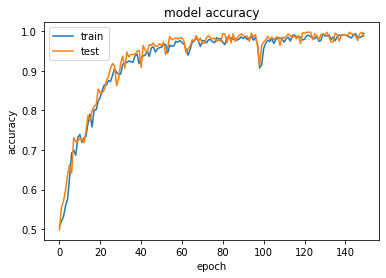

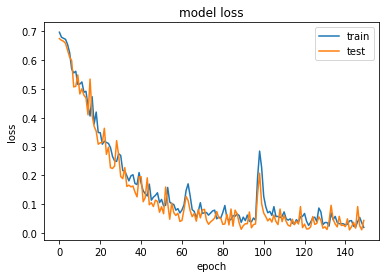

In [21]:
# running model
epochs = 150
my_model = get_model()
run_model(my_model, train_samples, validation_samples, train_image, validation_image, iteration=epochs, batch_size=batch_size)
my_model.save(r'/content/drive/My Drive/datasets/pet_class_data/model/model_'+str(epochs)+'_'+str(dt.datetime.now()))

In [22]:
history = my_model.history
max(history.history['accuracy']), max(history.history['val_accuracy'])

(0.9951287508010864, 0.9979166388511658)

In [23]:
min(history.history['loss']), min(history.history['val_loss'])

(0.018864145502448082, 0.010293012484908104)

**Sample prediction to check the model performance on new image**

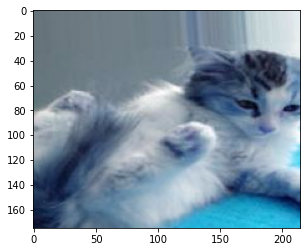

[[0]]


In [29]:
image = '../input/petclassdata/pet_class_data/test/cats/cats_0_1140.jpg'
img = cv2.imread(image)
plt.imshow(img)
plt.show()
img = cv2.resize(img,(150,150))
img = np.reshape(img, (1, 150, 150, 3))
classes = my_model.predict_classes(img)
print(classes)

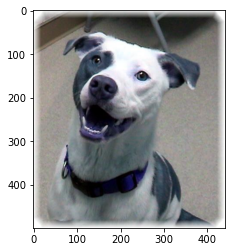

[[1]]


In [30]:
image = '../input/petclassdata/pet_class_data/test/dogs/101.jpg'
img = cv2.imread(image)
plt.imshow(img)
plt.show()
img = cv2.resize(img,(150,150))
img = np.reshape(img, (1, 150, 150, 3))
classes = my_model.predict_classes(img)
print(classes)